In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [8]:
sd = '2010-01-01'

In [9]:
ticker = "^NSEI"

In [10]:
data = yf.download(ticker, start=sd)

[*********************100%***********************]  1 of 1 completed


In [11]:
data.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-01-04  5200.899902  5238.450195  5167.100098  5232.200195  5232.200195   
2010-01-05  5277.149902  5288.350098  5242.399902  5277.899902  5277.899902   
2010-01-06  5278.149902  5310.850098  5260.049805  5281.799805  5281.799805   
2010-01-07  5281.799805  5302.549805  5244.750000  5263.100098  5263.100098   
2010-01-08  5264.250000  5276.750000  5234.700195  5244.750000  5244.750000   

            Volume  
Date                
2010-01-04       0  
2010-01-05       0  
2010-01-06       0  
2010-01-07       0  
2010-01-08       0

In [12]:
def computeMACD (df, n_fast, n_slow, n_smooth):
    data = df['Close']

    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name = 'MACD')
    MACDsig = pd.Series(MACD.ewm(span=n_smooth, min_periods=n_smooth).mean(), name='MACDsig')
    MACDhist = pd.Series(MACD - MACDsig, name = 'MACDhist')
    df = df.join(MACD)
    df = df.join(MACDsig)
    df = df.join(MACDhist)

    return df

In [18]:
#keltner channel
def get_kc(high, low, close, kc_lookback=20, multiplier=2, atr_lookback=10):   # parameter to be optimized are kc_lookback, multiplier,atr_lookback
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift()))
    tr3 = pd.DataFrame(abs(low - close.shift()))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(alpha = 1/atr_lookback).mean()

    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = close.ewm(kc_lookback).mean() + multiplier * atr
    kc_lower = close.ewm(kc_lookback).mean() - multiplier * atr

    return kc_middle, kc_upper, kc_lower

In [39]:
#Keltner Channel figure for each year
start_date = pd.to_datetime(sd)

<ipython-input-23-ff0c17e325bf>:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  year_data = data[str(year)]


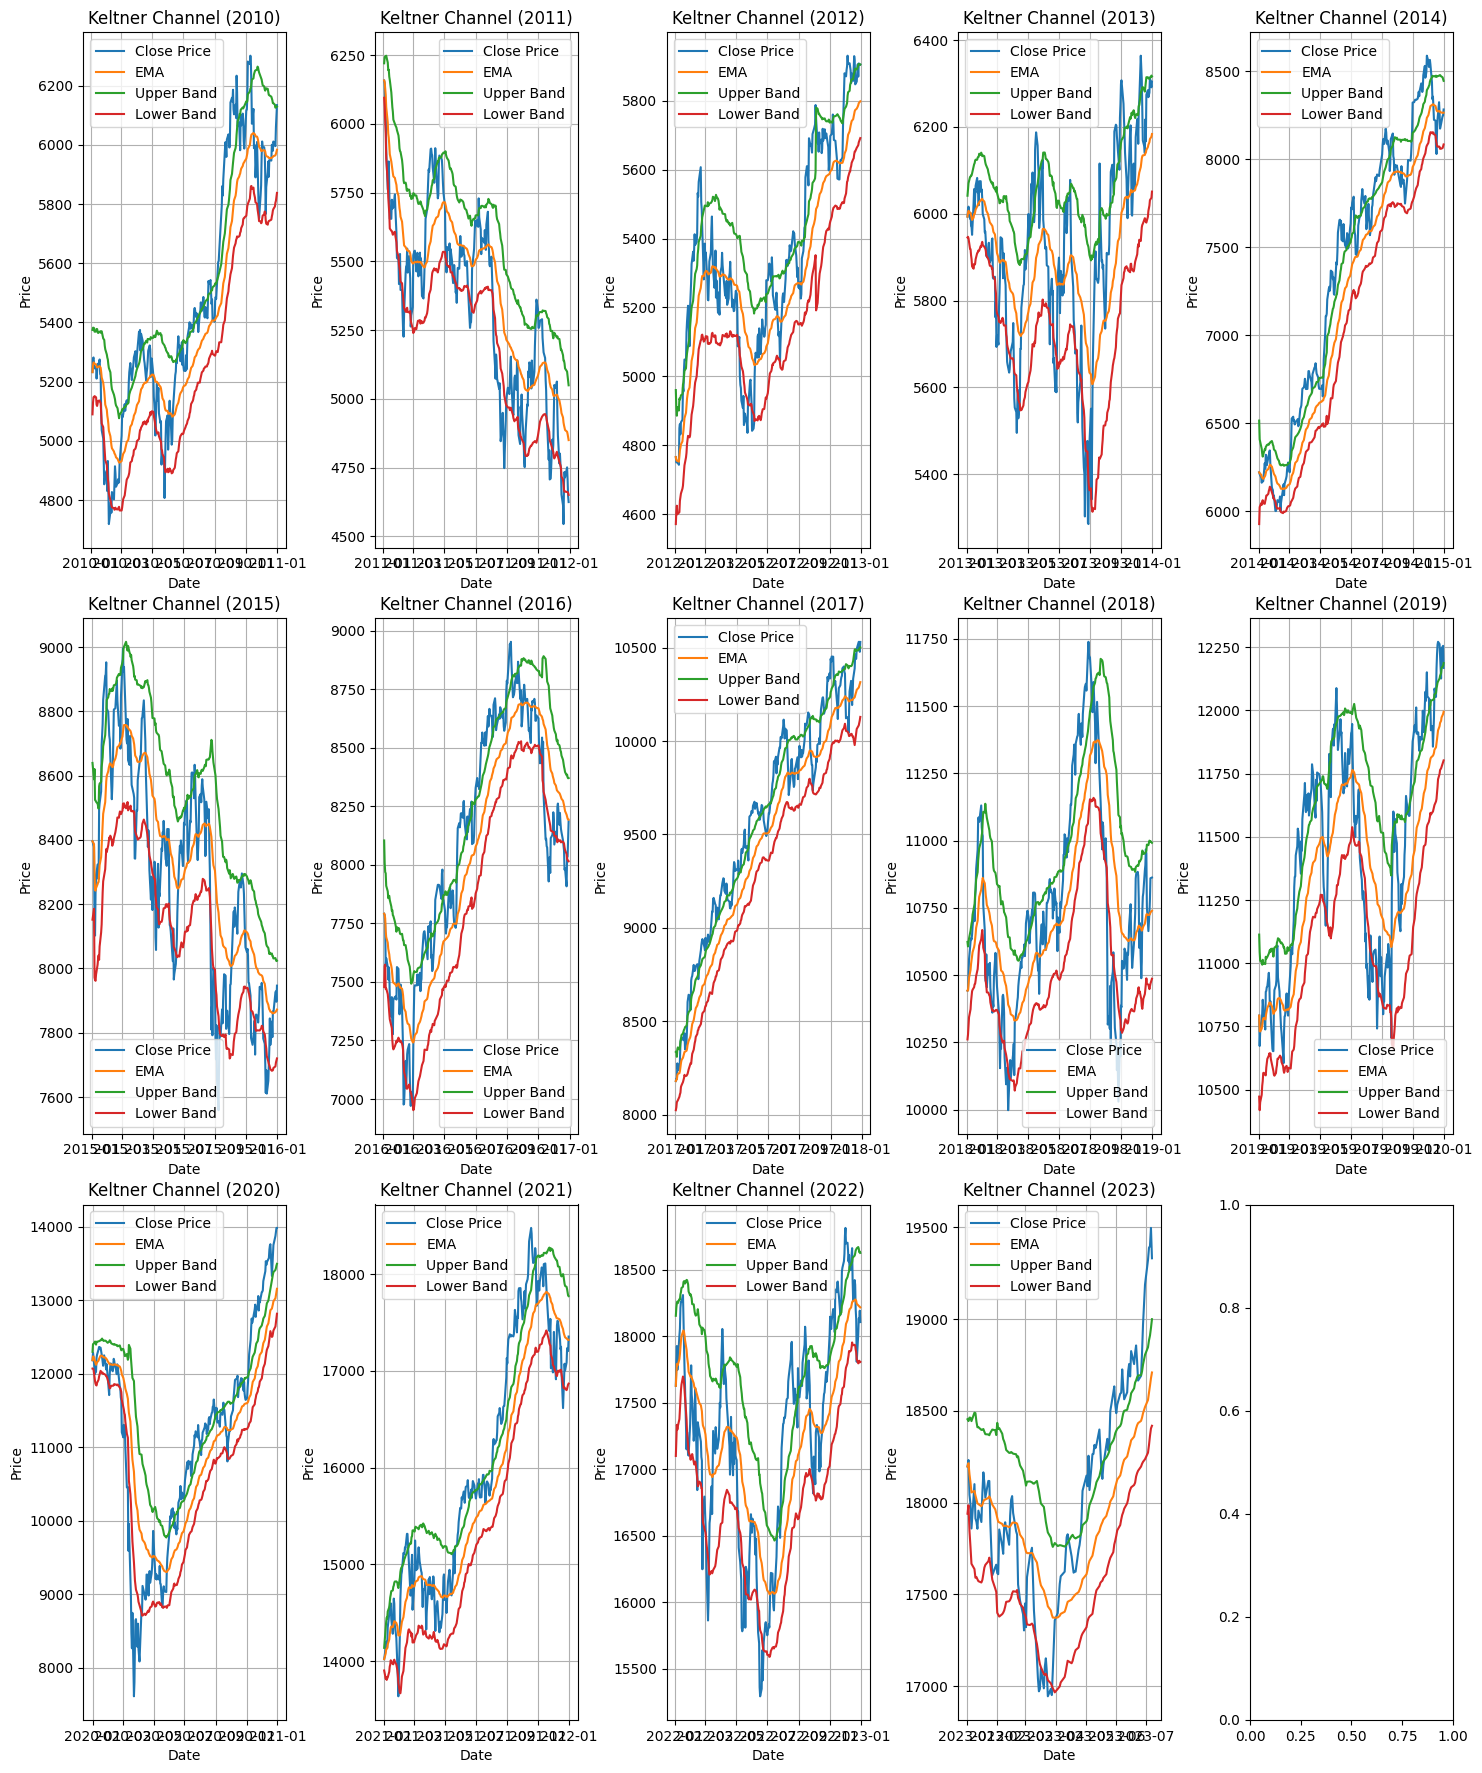

In [23]:
start_year = start_date.year
end_year = 2023
total_years = end_year - start_year + 1

# Calculate the number of rows and columns for the subplot grid
num_rows = (total_years + 1) // 5
num_cols = 5

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))
fig.tight_layout(pad=3.0)

for i, year in enumerate(range(start_year, end_year + 1)):
    year_data = data[str(year)]
    ema, upper_band,  lower_band = get_kc(year_data['High'],year_data['Low'],year_data['Close'])

    # Calculate subplot position
    row = i // num_cols
    col = i % num_cols

    # Plotting
    axs[row, col].plot(year_data.index, year_data['Close'], label='Close Price')
    axs[row, col].plot(year_data.index, ema, label='EMA')
    axs[row, col].plot(year_data.index, upper_band, label='Upper Band')
    axs[row, col].plot(year_data.index, lower_band, label='Lower Band')
    axs[row, col].set_title('Keltner Channel ({0})'.format(year))
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Price')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.show()

<ipython-input-26-664dd6330c5d>:13: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  year_data = data[str(year)]


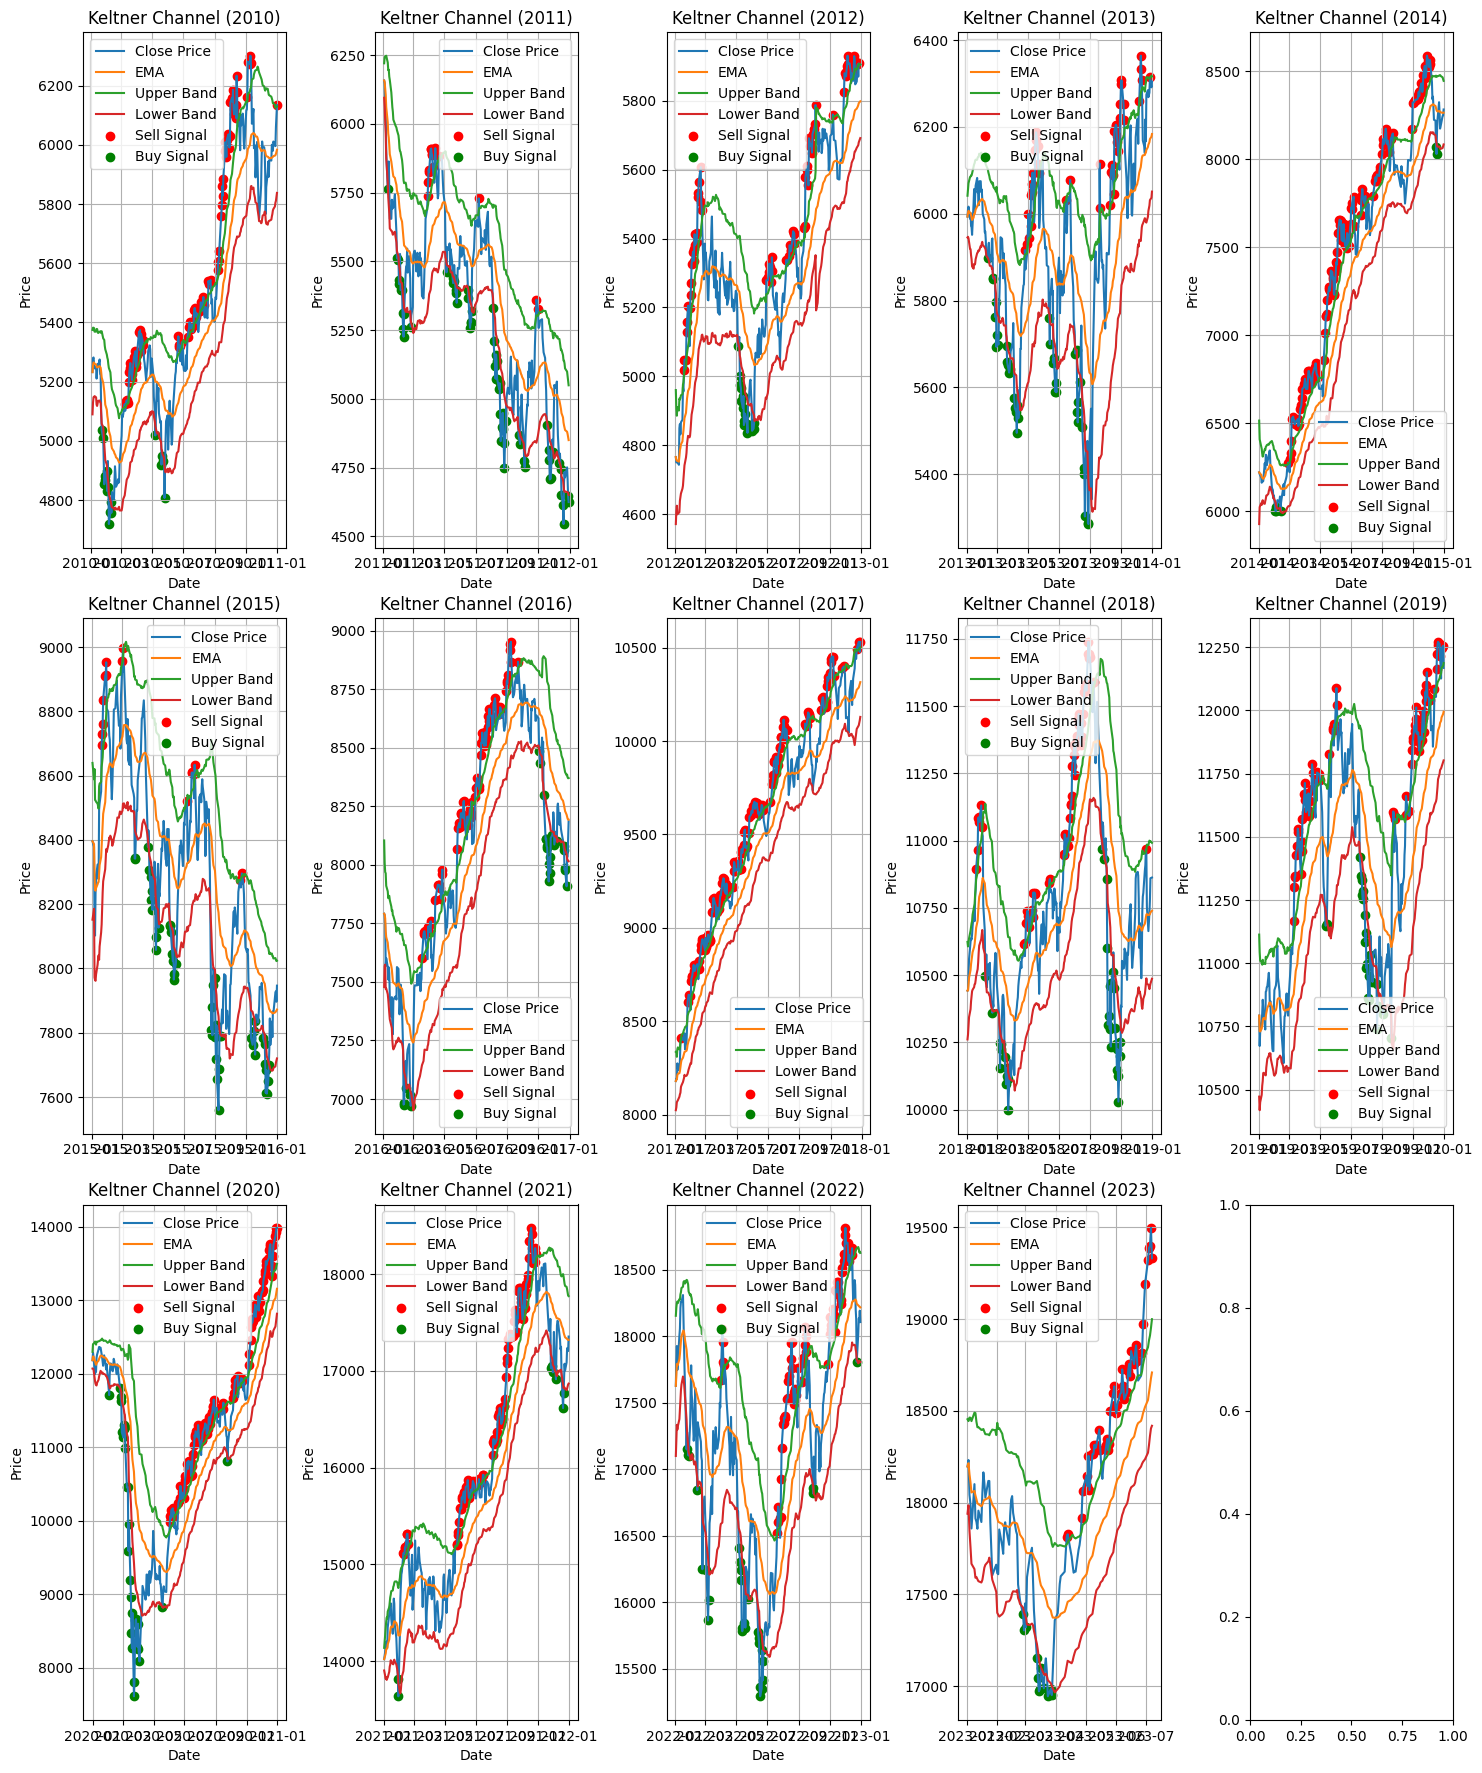

In [26]:
start_year = start_date.year
end_year = 2023
total_years = end_year - start_year + 1

# Calculate the number of rows and columns for the subplot grid
num_rows = (total_years + 1) // 5
num_cols = 5

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))
fig.tight_layout(pad=3.0)

for i, year in enumerate(range(start_year, end_year + 1)):
    year_data = data[str(year)]
    ema, upper_band,  lower_band = get_kc(year_data['High'],year_data['Low'],year_data['Close'])

    # Here we are generating sell and buy signals
    sell_signals = year_data[year_data['Close'] > upper_band]['Close']
    buy_signals = year_data[year_data['Close'] < lower_band]['Close']

    # Calculate subplot position
    row = i // num_cols
    col = i % num_cols

    # Plotting
    axs[row, col].plot(year_data.index, year_data['Close'], label='Close Price')
    axs[row, col].plot(year_data.index, ema, label='EMA')
    axs[row, col].plot(year_data.index, upper_band, label='Upper Band')
    axs[row, col].plot(year_data.index, lower_band, label='Lower Band')
    axs[row, col].scatter(sell_signals.index, sell_signals, color='red', label='Sell Signal', marker='o')
    axs[row, col].scatter(buy_signals.index, buy_signals, color='green', label='Buy Signal', marker='o')
    axs[row, col].set_title('Keltner Channel ({0})'.format(year))
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Price')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.show()

### Trading Strategy:
* If the price is below the lower line of the Keltner Channel, it indicates a potential buying opportunity.
* If the price is above the upper line of the Keltner Channel, it suggests a potential selling opportunity.

In [27]:
import plotly.graph_objects as go

In [31]:
start_year = start_date.year
end_year = 2023
total_years = end_year - start_year + 1

# Calculate the number of rows and columns for the subplot grid
num_rows = (total_years + 1) // 5
num_cols = 5


for i, year in enumerate(range(start_year, end_year + 1)):
    year_data = data[str(year)]

    # Preparing data for candlestick plot
    candlestick = go.Candlestick(
        x=year_data.index,
        open=year_data['Open'],
        high=year_data['High'],
        low=year_data['Low'],
        close=year_data['Close']
    )

    # Calculate subplot position
    row = i // num_cols
    col = i % num_cols

    # Plotting
    layout = go.Layout(
        title='Candlestick Chart ({0})'.format(year),
        xaxis=dict(title='Date'),
        yaxis=dict(title='Price'),
        showlegend=False
    )
    fig = go.Figure(data=[candlestick], layout=layout)
    fig.update_layout(height=400, width=1500)  # Set the desired chart size
    fig.show()

<ipython-input-31-00290638c86c>:11: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  year_data = data[str(year)]


<ipython-input-31-00290638c86c>:11: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



In [35]:
for year in range(start_date.year, 2023 + 1):
    year_data = data[str(year)]
    ema, upper_band,  lower_band = get_kc(year_data['High'],year_data['Low'],year_data['Close'])

    # Here we are preparing data for candlestick plot
    candlestick = go.Candlestick(
        x=year_data.index,
        open=year_data['Open'],
        high=year_data['High'],
        low=year_data['Low'],
        close=year_data['Close']
    )

    #Here we are plotting
    fig = go.Figure()

    # Here we are adding candlestick trace
    fig.add_trace(candlestick)

    # Here we are adding Keltner Channel lines
    fig.add_trace(go.Scatter(
        x=year_data.index, y=ema,
        mode='lines',
        name='EMA',
        line=dict(color='blue')
    ))
    fig.add_trace(go.Scatter(
        x=year_data.index, y=upper_band,
        mode='lines',
        name='Upper Band',
        line=dict(color='orange')
    ))
    fig.add_trace(go.Scatter(
        x=year_data.index, y=lower_band,
        mode='lines',
        name='Lower Band',
        line=dict(color='orange')
    ))

    # Here we are setting layout
    fig.update_layout(
        title='Keltner Channel and Candlestick Chart ({0})'.format(year),
        xaxis=dict(title='Date'),
        yaxis=dict(title='Price')
    )

    # Show the combined plot
    fig.show()

<ipython-input-35-b3a31a8b4815>:2: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



In [40]:

for year in range(start_date.year, 2023 + 1):
    year_data = data[str(year)]
    ema, upper_band,  lower_band = get_kc(year_data['High'],year_data['Low'],year_data['Close'])

    # Here we are preparing data for candlestick plot
    candlestick = go.Candlestick(
        x=year_data.index,
        open=year_data['Open'],
        high=year_data['High'],
        low=year_data['Low'],
        close=year_data['Close']
    )

    # Here we are plotting
    fig = go.Figure()

    # Here we are adding candlestick trace
    fig.add_trace(candlestick)

    # Here we are adding Keltner Channel lines
    fig.add_trace(go.Scatter(
        x=year_data.index, y=ema,
        mode='lines',
        name='EMA',
        line=dict(color='blue')
    ))
    fig.add_trace(go.Scatter(
        x=year_data.index, y=upper_band,
        mode='lines',
        name='Upper Band',
        line=dict(color='orange')
    ))
    fig.add_trace(go.Scatter(
        x=year_data.index, y=lower_band,
        mode='lines',
        name='Lower Band',
        line=dict(color='orange')
    ))

    # Here we are finding hammer candlestick pattern
    hammer_pattern = year_data[(year_data['Low'] - year_data['Open']) > 2 * (year_data['Close'] - year_data['Open'])]

    # Here we are generating buy and sell signals
    buy_signals = hammer_pattern['High'] + 0.01
    sell_signals = hammer_pattern['Low'] - 0.01

    # Here we are plotting buy signals
    fig.add_trace(go.Scatter(
        x=hammer_pattern.index,
        y=buy_signals,
        mode='markers',
        marker=dict(symbol="cross", color="green"),
        name='Buy Signals'
    ))

    # Here we are plotting sell signals
    fig.add_trace(go.Scatter(
        x=hammer_pattern.index,
        y=sell_signals,
        mode='markers',
        marker=dict(symbol="cross", color="red"),
        name='Sell Signals'
    ))

    # Here we are setting layout
    fig.update_layout(
        title='Keltner Channel and Candlestick Chart ({0})'.format(year),
        xaxis=dict(title='Date'),
        yaxis=dict(title='Price'),
        showlegend=True
    )

    fig.show()

<ipython-input-40-c36c660ab26e>:2: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



In [41]:
cumulative_returns = []
max_drawdowns = []
sharpe_ratios = []

In [42]:
#Returns, Drawdown, and Sharpe Ratio
returns = (hammer_pattern['Close'].pct_change() + 1).cumprod()
cumulative_returns.append(returns[-1] - 1)

# Drawdown
equity_curve = returns.cumprod()
previous_peaks = equity_curve.cummax()
drawdowns = (equity_curve - previous_peaks) / previous_peaks
max_drawdowns.append(drawdowns.max())

# Sharpe Ratio
daily_returns = hammer_pattern['Close'].pct_change()
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
sharpe_ratios.append(sharpe_ratio)

In [43]:
mean_cumulative_returns = np.mean(cumulative_returns)
mean_max_drawdowns = np.mean(max_drawdowns)
mean_sharpe_ratios = np.mean(sharpe_ratios)

In [44]:
print("Mean Cumulative Returns: ", mean_cumulative_returns)
print("Mean Maximum Drawdowns: ", mean_max_drawdowns)
print("Mean Sharpe Ratios: ", mean_sharpe_ratios)

Mean Cumulative Returns:  0.07143242198789967
Mean Maximum Drawdowns:  0.0
Mean Sharpe Ratios:  2.1100340620528715
